In [1]:
import json
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns




In [2]:
# Load the JSON data
with open('./Fit/All data/raw_com.google.step_count.delta_com.google.and.json', 'r') as file:
    data = json.load(file)

# Extract the data points
data_points = data['Data Points']



In [3]:
# Starting an empty list to store the transformed data
transformed_data = []

for point in data_points:
    steps = point['fitValue'][0]['value']['intVal']
    start_time = int(point['startTimeNanos'])
    end_time = int(point['endTimeNanos'])
    
    # Converting nanoseconds to datetime
    start_datetime = datetime.fromtimestamp(start_time / 1e9)
    end_datetime = datetime.fromtimestamp(end_time / 1e9)
    
    transformed_data.append({
        'steps': steps,
        'start_time': start_datetime,
        'end_time': end_datetime
    })

df = pd.DataFrame(transformed_data)


In [4]:
# Aggregating 
df['date'] = df['start_time'].dt.date
daily_steps = df.groupby('date')['steps'].sum().reset_index()

print(daily_steps)


          date   steps
0   2024-06-08    3615
1   2024-06-09    2491
2   2024-06-10   18051
3   2024-06-11   13049
4   2024-06-12   16118
5   2024-06-13   13301
6   2024-06-14   16142
7   2024-06-15    1950
8   2024-06-16    8883
9   2024-06-17   18681
10  2024-06-18    9249
11  2024-06-19    9895
12  2024-06-20   11682
13  2024-06-21    2262
14  2024-06-22    2939
15  2024-06-23    9574
16  2024-06-24   16989
17  2024-06-25    9963
18  2024-06-26    9079
19  2024-06-27   16190
20  2024-06-28   13895
21  2024-06-29    2641
22  2024-06-30    9679
23  2024-07-01    8469
24  2024-07-02    8051
25  2024-07-03    8659
26  2024-07-04   12646
27  2024-07-05    7947
28  2024-07-06    4552
29  2024-07-07    2105
30  2024-07-08    9542
31  2024-07-09   15188
32  2024-07-10    8000
33  2024-07-11  196007


### I will separate this data into weeks before merging with the football performance data. This will help in making the analysis more structured and easier to manage.

In [5]:
daily_steps['date'] = pd.to_datetime(daily_steps['date'])

# Subtract 4 days to shift the week start to Friday
daily_steps['adjusted_date'] = daily_steps['date'] - pd.Timedelta(days=4)

# Sort by adjusted_date to ensure weeks are calculated correctly
daily_steps = daily_steps.sort_values('adjusted_date')

# Add a 'week' column based on adjusted_date
daily_steps['week'] = daily_steps['adjusted_date'].dt.isocalendar().week

# Group by week and sum the steps
weekly_steps_sum = daily_steps.groupby('week')['steps'].sum().reset_index()

# Merge the weekly sums back into the original DataFrame
df_steps = pd.merge(daily_steps, weekly_steps_sum, on='week', suffixes=('', '_weekly'))

# Rename columns for clarity
df_steps.rename(columns={'steps_weekly': 'weekly_steps'}, inplace=True)

# Enumerate the week column starting from 1
df_steps['week'] = df_steps['week'].rank(method='dense').astype(int)

# Drop the adjusted_date column as it's no longer needed
df_steps.drop(columns=['adjusted_date'], inplace=True)

print(df_steps.tail(10))


         date   steps  week  weekly_steps
24 2024-07-02    8051     4         64040
25 2024-07-03    8659     4         64040
26 2024-07-04   12646     4         64040
27 2024-07-05    7947     5        243341
28 2024-07-06    4552     5        243341
29 2024-07-07    2105     5        243341
30 2024-07-08    9542     5        243341
31 2024-07-09   15188     5        243341
32 2024-07-10    8000     5        243341
33 2024-07-11  196007     5        243341


### I noticed some inconsistencies in the day 2024-07-11, I believe that amount of steps is wrong.
### "33  2024-07-11  196007"
### I will need to fix this and copy mannually from the app, as it's just one data


In [6]:
# Updating the steps
df_steps.loc[df_steps.index == 33, 'steps'] = 9362

# Recalculate the weekly steps for week 5
week_5_steps = df_steps[df_steps['week'] == 5]['steps'].sum()

# Update the weekly_steps column for all entries in week 5
df_steps.loc[df_steps['week'] == 5, 'weekly_steps'] = week_5_steps

print(df_steps)


         date  steps  week  weekly_steps
0  2024-06-08   3615     1         66625
1  2024-06-09   2491     1         66625
2  2024-06-10  18051     1         66625
3  2024-06-11  13049     1         66625
4  2024-06-12  16118     1         66625
5  2024-06-13  13301     1         66625
6  2024-06-14  16142     2         76482
7  2024-06-15   1950     2         76482
8  2024-06-16   8883     2         76482
9  2024-06-17  18681     2         76482
10 2024-06-18   9249     2         76482
11 2024-06-19   9895     2         76482
12 2024-06-20  11682     2         76482
13 2024-06-21   2262     3         66996
14 2024-06-22   2939     3         66996
15 2024-06-23   9574     3         66996
16 2024-06-24  16989     3         66996
17 2024-06-25   9963     3         66996
18 2024-06-26   9079     3         66996
19 2024-06-27  16190     3         66996
20 2024-06-28  13895     4         64040
21 2024-06-29   2641     4         64040
22 2024-06-30   9679     4         64040
23 2024-07-01   

# Merging the performance file into the dataframe

In [7]:

# Loading the CSV file
football_performance = pd.read_csv('Football performance.csv')

# I need to raname the column to match the existing dataframe column
football_performance.rename(columns={'Football Date': 'date'}, inplace=True)

# Convert the 'date' column to datetime to ensure it matches the 'date' format in df_steps
football_performance['date'] = pd.to_datetime(football_performance['date'])

# Merging both column by the date column
df = pd.merge(df_steps, football_performance, on='date', how='left')

# Display the merged DataFrame
print(df)


         date  steps  week  weekly_steps  Goal Scored  Goal Assisted  Team Win
0  2024-06-08   3615     1         66625          NaN            NaN       NaN
1  2024-06-09   2491     1         66625          NaN            NaN       NaN
2  2024-06-10  18051     1         66625          NaN            NaN       NaN
3  2024-06-11  13049     1         66625          NaN            NaN       NaN
4  2024-06-12  16118     1         66625          NaN            NaN       NaN
5  2024-06-13  13301     1         66625          4.0            1.0       4.0
6  2024-06-14  16142     2         76482          NaN            NaN       NaN
7  2024-06-15   1950     2         76482          NaN            NaN       NaN
8  2024-06-16   8883     2         76482          NaN            NaN       NaN
9  2024-06-17  18681     2         76482          NaN            NaN       NaN
10 2024-06-18   9249     2         76482          NaN            NaN       NaN
11 2024-06-19   9895     2         76482          Na

### I will need to replace the NaN values with 0, in order to facilitate any further visualization.
### I will also create a new column to be more clear to compare days that I played football to days that I didn't play.

In [8]:
# Fill NaN values with zeros
df.fillna(0, inplace=True)

# Create a new column to indicate football days
df['football_day'] = df['Goal Scored'] > 0

print(df)

         date  steps  week  weekly_steps  Goal Scored  Goal Assisted  \
0  2024-06-08   3615     1         66625          0.0            0.0   
1  2024-06-09   2491     1         66625          0.0            0.0   
2  2024-06-10  18051     1         66625          0.0            0.0   
3  2024-06-11  13049     1         66625          0.0            0.0   
4  2024-06-12  16118     1         66625          0.0            0.0   
5  2024-06-13  13301     1         66625          4.0            1.0   
6  2024-06-14  16142     2         76482          0.0            0.0   
7  2024-06-15   1950     2         76482          0.0            0.0   
8  2024-06-16   8883     2         76482          0.0            0.0   
9  2024-06-17  18681     2         76482          0.0            0.0   
10 2024-06-18   9249     2         76482          0.0            0.0   
11 2024-06-19   9895     2         76482          0.0            0.0   
12 2024-06-20  11682     2         76482          5.0           

## Let's explore this dataframe, questions I want to answer:
## Correlation Analysis:
### 1 - Is there a relationship between the weekly steps total and the week's football performance? If so, how strong it is?
### 2 - Is there a relationship between the total steps on the football day and the football performance? If so, how strong it is?
### 3 - which of them has a stronger correlation to my football performance? Is it the total steps on football days or the total steps per week? 
## Visualization:
### 1 - Scatter Plots: Use scatter plots to visualize relationships between steps and football performance metrics.

In [9]:
## Correlation Analysis:
### 1 - Is there a relationship between the weekly steps total and the week's football performance?

# Grouping the data weekly
weekly_performance = df.groupby('week').agg({
    'weekly_steps': 'first',
    'Goal Scored': 'sum',
    'Goal Assisted': 'sum',
    'Team Win': 'sum'
}).reset_index()

print(weekly_performance)

   week  weekly_steps  Goal Scored  Goal Assisted  Team Win
0     1         66625          4.0            1.0       4.0
1     2         76482          5.0            1.0       7.0
2     3         66996          3.0            4.0       5.0
3     4         64040          3.0            3.0       5.0
4     5         56696          1.0            1.0       3.0


In [10]:
# Calculate the correlation coefficients
weekly_performance_corr = weekly_performance.corr()

print(weekly_performance_corr)

                   week  weekly_steps  Goal Scored  Goal Assisted  Team Win
week           1.000000     -0.719521    -0.852803       0.223607 -0.426401
weekly_steps  -0.719521      1.000000     0.950553      -0.044108  0.928839
Goal Scored   -0.852803      0.950553     1.000000      -0.119183  0.818182
Goal Assisted  0.223607     -0.044108    -0.119183       1.000000  0.119183
Team Win      -0.426401      0.928839     0.818182       0.119183  1.000000


## notes:
* A correlation coefficient close to 1 implies a strong positive relationship.
* A correlation coefficient close to -1 implies a strong negative relationship.
* A correlation coefficient around 0 implies no relationship.

## Weekly Steps and Goals Scored (0.95):
* This number is very close to 1, which means there's a strong positive relationship. When the friends walk more steps in a week, they tend to score more goals in football.

## Weekly Steps and Goals Assisted (-0.04):
* This number is very close to 0, which means there's almost no relationship. Walking more or fewer steps doesn't seem to affect how many goals they help others score (assists).

## Weekly Steps and Team Wins (0.93):
* This number is also close to 1, meaning there's a strong positive relationship. When the friends walk more steps in a week, their team tends to win more often.


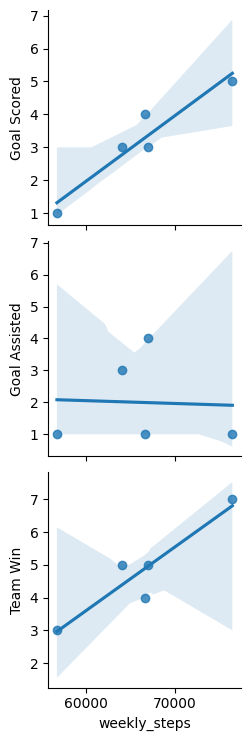

In [11]:

# Scatter plots
sns.pairplot(weekly_performance, x_vars=['weekly_steps'], y_vars=['Goal Scored', 'Goal Assisted', 'Team Win'], kind='reg')
plt.show()


## Summary:
* ## When I walk more steps in a week, I score more goals and my team wins more games.
* ## Walking more steps doesn't really change how many goals I assist.

# 2 - Is there a relationship between the total steps on the football day and the football performance?

In [12]:
print(df.tail())

         date  steps  week  weekly_steps  Goal Scored  Goal Assisted  \
29 2024-07-07   2105     5         56696          0.0            0.0   
30 2024-07-08   9542     5         56696          0.0            0.0   
31 2024-07-09  15188     5         56696          0.0            0.0   
32 2024-07-10   8000     5         56696          0.0            0.0   
33 2024-07-11   9362     5         56696          1.0            1.0   

    Team Win  football_day  
29       0.0         False  
30       0.0         False  
31       0.0         False  
32       0.0         False  
33       3.0          True  


### I will use the column football_day to filter the dataframe based on the football_day = True, then I will check the correlation coefficients between steps on football days and the football performance metrics (Goal Scored, Goal Assisted, Team Win).

In [13]:
football_days_df = df[df['football_day'] == True]


football_day_corr = football_days_df[['steps', 'Goal Scored', 'Goal Assisted', 'Team Win']].corr()

print(football_day_corr)

                  steps  Goal Scored  Goal Assisted  Team Win
steps          1.000000     0.359797       0.759796  0.269617
Goal Scored    0.359797     1.000000      -0.119183  0.818182
Goal Assisted  0.759796    -0.119183       1.000000  0.119183
Team Win       0.269617     0.818182       0.119183  1.000000


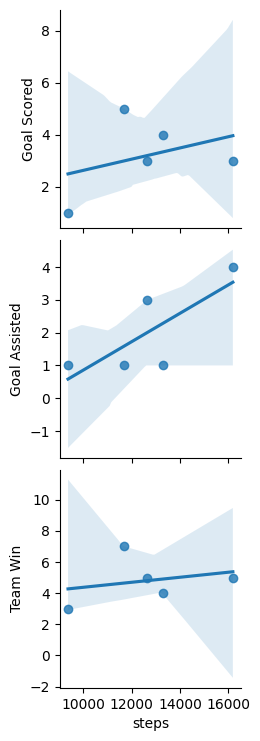

In [14]:
football_days_data = df[df['football_day']]

sns.pairplot(football_days_data, x_vars=['steps'], y_vars=['Goal Scored', 'Goal Assisted', 'Team Win'], kind='reg')
plt.show()



## Summary:

* There is a strong positive relationship between the total steps on football days and the number of assists made during football games.
* There is a moderate positive relationship between the total steps on football days and the number of goals scored.
* There is a weak positive relationship between the total steps on football days and the number of team wins.

# 3 - which of them has a stronger correlation to my football performance? Is it the total steps on football days or the total steps per week? 


In [15]:
print(football_day_corr)
print(weekly_performance_corr)


                  steps  Goal Scored  Goal Assisted  Team Win
steps          1.000000     0.359797       0.759796  0.269617
Goal Scored    0.359797     1.000000      -0.119183  0.818182
Goal Assisted  0.759796    -0.119183       1.000000  0.119183
Team Win       0.269617     0.818182       0.119183  1.000000
                   week  weekly_steps  Goal Scored  Goal Assisted  Team Win
week           1.000000     -0.719521    -0.852803       0.223607 -0.426401
weekly_steps  -0.719521      1.000000     0.950553      -0.044108  0.928839
Goal Scored   -0.852803      0.950553     1.000000      -0.119183  0.818182
Goal Assisted  0.223607     -0.044108    -0.119183       1.000000  0.119183
Team Win      -0.426401      0.928839     0.818182       0.119183  1.000000



* Both football days and weekly steps show similar correlations with Goal Scored and Team Win. The correlation coefficients are identical for Goal Scored and Team Win, suggesting no significant difference in correlation strength between the two analyses.

* For Goal Assisted, the correlation coefficient from football days (-0.044108) indicates a weaker relationship compared to the weekly performance analysis. Therefore, weekly steps might have a slightly stronger correlation with Goal Assisted compared to football days.


# ANSWERING THE QUESTIONS:

## 1 - Is there a relationship between the weekly steps total and the week's football performance? If so, how strong it is?
### There is a relationship between the weekly steps total and the week's football performance. The correlation coefficients are as follows:

* Goal Scored: Positive correlation of approximately 0.951.
* Goal Assisted: Weak negative correlation of approximately -0.044.
* Team Win: Positive correlation of approximately 0.929.
### These coefficients suggest a strong positive relationship between weekly steps and Goal Scored and Team Win, indicating that higher weekly step totals generally coincide with more goals scored and more team wins.


## 2 - Is there a relationship between the total steps on the football day and the football performance? If so, how strong it is?
### There is a relationship between the total steps on the football day and football performance metrics. The correlation coefficients are:
* Goal Scored: Positive correlation of approximately 0.360.
* Goal Assisted: Positive correlation of approximately 0.760.
* Team Win: Positive correlation of approximately 0.270.
### These coefficients indicate a moderate to strong positive relationship between steps on football days and football performance metrics, suggesting that higher steps on football days tend to coincide with more goals scored, more assists, and more team wins.


## 3 - Which of them has a stronger correlation to my football performance? Is it the total steps on football days or the total steps per week?
* Goal Scored: The correlation coefficient with weekly steps (0.951) is higher than with steps on football days (0.360).
* Goal Assisted: The correlation coefficient with steps on football days (0.760) is higher than with weekly steps (-0.044).
* Team Win: The correlation coefficient with weekly steps (0.929) is higher than with steps on football days (0.270).

## Overall, for Goal Scored and Team Win, the total steps per week (weekly_steps) shows a stronger correlation with football performance. However, for Goal Assisted, the total steps on football days exhibit a stronger correlation.